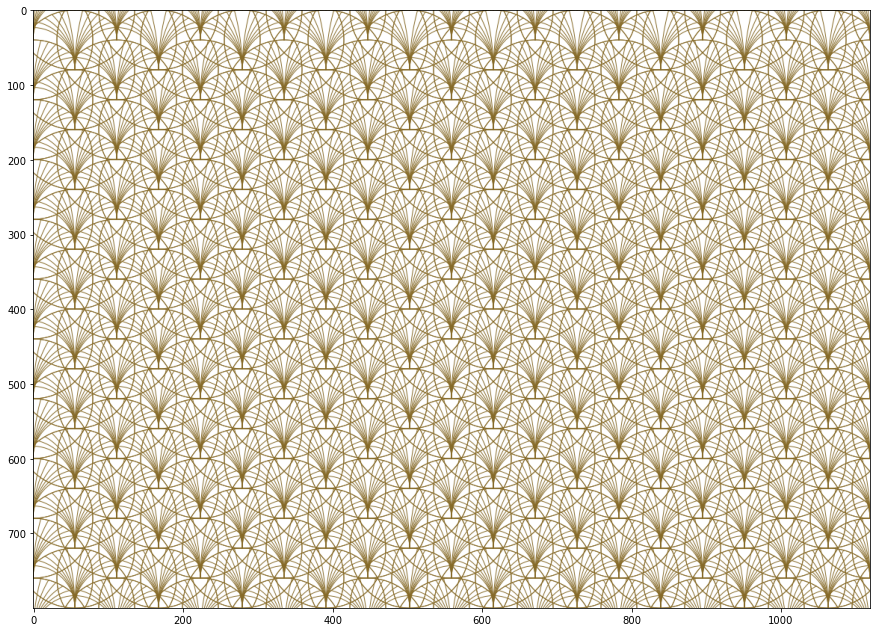

In [306]:
# Generativepy example to create an artdeco like horizontal/vertical repetive symmetrical pattern
from generativepy.geometry import Bezier, Polygon, Line, Circle, Text, Transform
from generativepy.drawing import make_image, setup, make_svg,make_image_frame
from generativepy.drawing import make_image, setup, SQUARE, BUTT, ROUND, BEVEL, MITER, EVEN_ODD, WINDING
from generativepy.color import Color

import numpy as np
import math
import sympy
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = [15, 15]

# ensure angles are between -180° and +180° 
def modulo2pi(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    degrees=round(math.degrees(new_angle),2)
    new_angle=math.radians(degrees)
    return new_angle

# Add Arcs, Circles and Bezier to the generativepu Turtle
# Turtle is a drawing move with draw as if it was a track of an entity moving around
class NewTurtle():

    def __init__(self, ctx):
        self.ctx = ctx
        self.heading = 0
        self.x = 0
        self.y = 0
        self.color = Color(0)
        self.line_width = 1
        self.dash = []
        self.cap = SQUARE
        self.stack = []
    # preserve states
    def push(self):
        state = self.heading, self.x, self.y, self.color, self.line_width, self.dash, self.cap
        self.stack.append(state)
        return self

    # restore states
    def pop(self):
        state = self.stack.pop()
        self.heading, self.x, self.y, self.color, self.line_width, self.dash, self.cap = state
        return self
    
    # draw a line forward end at a distance in the current direction heading
    def forward(self, distance):
        p1 = self.x, self.y
        self.x += distance*math.cos(self.heading)
        self.y += distance*math.sin(self.heading)
        Line(self.ctx).of_start_end(p1, (self.x, self.y))\
                      .stroke(self.color, line_width=self.line_width, dash=self.dash, cap=self.cap)
        return self

    # move to point at a distance in the current direction heading without drawing
    def move(self, distance):
        self.x += distance*math.cos(self.heading)
        self.y += distance*math.sin(self.heading)
        return self

    # move to point a given point without drawing
    def move_to(self, x, y):
        self.x = x
        self.y = y
        return self

    # draw a circle from current point to current point with a center at a radius distance in the current directio
    def circle(self, radius,fillcolor,strokecolor,strokewidth): 
        Circle(self.ctx).of_center_radius((self.x+radius*math.cos(self.heading), self.y+radius*math.sin(self.heading)), abs(radius)).fill_stroke(fillcolor,strokecolor, strokewidth)
        return self
    
    # draw a curve to a given offset with a change of direction heading
    def curve(self, dx, dy,angle): 
        if dx==0 and dy==0:
            return self
        u = np.array([1,0])
        v = np.array([dx,dy])
        turnangle=math.atan2(v[1]*u[0]-v[0]*u[1],v[0]*u[0]+v[1]*u[1])
        if math.cos(turnangle-self.heading)<0:
            turnback=True
        else:
            turnback=False
        p0 = self.x, self.y
        px,py = self.x+dx,self.y+dy

        pend=px,py
        l1=sympy.Line(sympy.Point(self.x, self.y), slope=math.tan(self.heading))
        l2=sympy.Line(sympy.Point(px,py), slope=math.tan(self.heading+angle))
        if sympy.Line.are_concurrent(l1, l2):
            intersection = l1.intersection(l2)
            xinter=intersection[0].x
            yinter=intersection[0].y
            print(p0,pend,xinter,yinter)
            if turnback:
                dx1=xinter-self.x
                dy1=yinter-self.y
                p1=self.x-dx1,self.y-dy1
                p2=xinter,yinter
            else:

                p1=xinter,yinter
                p2=xinter,yinter
            self.x = px
            self.y = py
            self.heading += angle
            print(p0, p1,p2, (px, py))
            Bezier(self.ctx).of_abcd(p0, p1,p2, (px, py))\
                          .stroke(self.color, line_width=self.line_width, dash=self.dash, cap=self.cap)
        return self
    
    # turn left with a given angle
    def left(self, angle):
        self.heading -= angle
        self.heading=modulo2pi(self.heading)
        return self
    
    # turn right with a given angle
    def right(self, angle):
        self.heading += angle
        self.heading=modulo2pi(self.heading)
        return self
    
    # change direction heading
    def set_heading(self, angle):
        self.last_heading = self.heading 
        self.heading = self.heading=modulo2pi(angle)
        return self

    # set drawing style
    def set_style(self, color=Color(0), line_width=1, dash=None, cap=SQUARE):
        self.color = color
        self.line_width = line_width
        if not dash:
            self.dash = []
        else:
            self.dash = dash
        self.cap = cap
        return self

    # draw an arc starting at current point tangent to current direction finishing at angle
    def arc(self, angle,center,radius,strokecolor,strokewidth):
        start=self.heading
        stop=angle 
        Circle(self.ctx).of_center_radius(center, radius).as_arc(start, stop).stroke(strokecolor, strokewidth)
        #.as_arc(start, stop).fill_stroke(fillcolor,strokecolor, strokewidth)
        # draw an arc starting at current point tangent to current direction finishing at angle

    def circle(self, center,radius,strokecolor,strokewidth):

        Circle(self.ctx).of_center_radius(center, radius).stroke(strokecolor, strokewidth)
        #.as_arc(start, stop).fill_stroke(fillcolor,strokecolor, strokewidth)

    # draw an arc toward left (counter clockwise)    
    def arcleft(self, angle,radius,strokecolor,strokewidth):
        hbefore=self.heading

        radiusheading=self.heading - pi/2
        stop=modulo2pi(self.heading+pi/2)
        start=stop-abs(angle)
        self.heading=start
        radius=abs(radius)
        center=(self.x+radius*math.cos(radiusheading), self.y+radius*math.sin(radiusheading))
        self.arc(stop,center,radius,strokecolor,strokewidth)
        self.x+=radius*math.cos(self.heading)
        self.y+=radius*math.sin(self.heading)
        self.x-=radius*math.cos(stop)
        self.y-=radius*math.sin(stop)
        self.heading=hbefore-angle
        return self

    # draw an arc toward right (clockwise)  
    def arcright(self,angle,radius,strokecolor,strokewidth):
        hbefore=self.heading
        radiusheading=self.heading + pi/2
        start=modulo2pi(self.heading- pi/2)
        stop=start+abs(angle)        
        self.heading=start
        radius=abs(radius)
        center=(self.x+radius*math.cos(radiusheading), self.y+radius*math.sin(radiusheading))
        self.arc(stop,center,radius,strokecolor,strokewidth)
        self.x-=radius*math.cos(self.heading)
        self.y-=radius*math.sin(self.heading)
        self.x+=radius*math.cos(stop)
        self.y+=radius*math.sin(stop)
        self.heading=hbefore+angle
        return self 
    
# Some Pattern elements 

# left part of the pattern. A mirror transform is used to create the right part
def drawleftpart(ctx,turtle):
    global pi
    global h_count
    global v_count
    global radius
    global arcradius
    global arcangle
    global number_of_arcs
    global stepangle
    global endangle
    global stop
    global half_pattern_w
    global pattern_h
    # some colors defined
    r,g,b=0x87/256,0x6a/256,0x28/256
    
    turtle.move_to(half_pattern_w,pattern_h)
    turtle.circle((turtle.x,turtle.y),radius,Color(r,g,b),1)
    turtle.set_heading(-pi/2)
    # Now start drawing using push and pop to restore position when several subpatterns are connected to a given point    

    turtle.push().set_style(Color(r,g,b),line_width=1).pop()
    
    for i in range(1,number_of_arcs+1):
        iarcangle=(i*stepangle)
        midarcradius=radius/(2*math.sin(iarcangle))
        iarcangle*=2
        turtle.push()
        turtle.set_heading(0)
        turtle.left(pi/2)
        turtle.arcleft(iarcangle,midarcradius,Color(r,g,b),1)
        turtle.pop()


# draw full pattern by mirroring left part
def drawpattern(ctx,turtle): 
    turtle.set_heading(0)
    drawleftpart(ctx,turtle)
    with Transform(ctx).translate(0, 0):
        with Transform(ctx).scale(-1, 1, (half_pattern_w, 0)):
            turtle.set_heading(0)
            drawleftpart(ctx,turtle)

# draw with iterations and offsets to repeat pattern to fill the defined area. Some parts are drawn outside the final zone
# to ensure no holes in the resulting drawing 
def draw(ctx, width, height, frame_no, frame_count):
    global pi
    global h_count
    global v_count
    global radius
    global arcradius
    global arcangle
    global number_of_arcs
    global stepangle
    global endangle
    global stop
    global half_pattern_w
    global pattern_h
    setup(ctx, width, height, background=Color(1))
    turtle = NewTurtle(ctx)
    stop=False
    # loop patterns with horizontal and vertical offsets
    for i in range(h_count+1):
        for j in range(v_count+1):
            with Transform(ctx).translate(2*i*half_pattern_w,(j-1)*pattern_h):
                drawpattern(ctx,turtle)
            # end of vertical loop
        # end of horizontal loop
        
    # shift half of height to fill gaps
    for i in range(h_count+1):
        for j in range(v_count+1):
            with Transform(ctx).translate(2*(i-1)*half_pattern_w+half_pattern_w,pattern_h/2+(j-1)*pattern_h):
                drawpattern(ctx,turtle)
                # 
            # end of vertical loop
        # end of horizontal loop
        
# some global variables
global pi
global h_count
global v_count
global radius
global arcradius
global arcangle
global number_of_arcs
global stepangle
global endangle
global stop
global half_pattern_w
global pattern_h
pi=math.pi
radius=80
arcangle=pi/4
arcradius=radius/(2*math.sin(arcangle))
number_of_arcs=6
endangle=arcangle
stepangle=endangle/number_of_arcs

v_count=10
h_count=10
half_pattern_w=int(math.cos(arcangle)*radius)
pattern_h=int(radius)
w=h_count*2*half_pattern_w
h=v_count*pattern_h
# make an image frame to display below
stop=0
a=make_image_frame(draw,w, h,3)
plt.imshow(a)
plt.show()
# make a svg from patterns
make_svg("artdeco.svg", draw,w, h)